In [1]:
import json

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, ConcatDataset

from Encoder import PerSec, PerSecCNN
from quantizer import GumbelVectorQuantizer
from custom_dataset import ContrastiveLearningDataset
from contrastive_loss import ContrastiveLoss

config = json.load(open('config.json'), 'r')

In [2]:
activations = {}
def get_activation(name):
	def hook(model, input, output):
		activations[name] = output.clone()
	return hook

In [4]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if config["model"]["Vit-base Encoder"]:
	PerSec = PerSec(img_size=(32, 384), in_channels=3).to(device)
	PerSec.lstm.requires_grad = False
	stroke_quantizer = GumbelVectorQuantizer(extracted_feature_size=64, num_groups=2, num_vectors=256, temperature=0.5).to(device)
	semantic_quantizer = GumbelVectorQuantizer(extracted_feature_size=512, num_groups=2, num_vectors=256, temperature=0.5).to(device)
	PerSec.stage1.register_forward_hook(get_activation('STCP_input'))
	PerSec.stage4.register_forward_hook(get_activation('SECP_input'))
else:
	PerSec = PerSecCNN(img_size=(32, 384), in_channels=3).to(device)
	PerSec.lstm.requires_grad = False
	stroke_quantizer = GumbelVectorQuantizer(extracted_feature_size=256, num_groups=2, num_vectors=256, temperature=0.5).to(device)
	semantic_quantizer = GumbelVectorQuantizer(extracted_feature_size=512, num_groups=2, num_vectors=256, temperature=0.5).to(device)
	PerSec.conv3.register_forward_hook(get_activation('STCP_input'))
	PerSec.conv6.register_forward_hook(get_activation('SECP_input'))

PerSec.stroke_context_aggregator.register_forward_hook(get_activation('stroke_context_aggregator'))
PerSec.semantic_context_aggregator.register_forward_hook(get_activation('semantic_context_aggregator'))

In [5]:
random_data = torch.randn(1, 3, 32, 384).to(device)
_, _ = PerSec(random_data)

p_low = 0.2
p_high = 0.15

LOW_LENGTH = activations['STCP_input'].shape[2] * activations['STCP_input'].shape[3]
HIGH_LENGTH = activations['SECP_input'].shape[2] * activations['SECP_input'].shape[3]

MASK_NUM_LOW =  int(LOW_LENGTH * p_low)
MASK_NUM_HIGH = int(HIGH_LENGTH * p_high)

In [6]:
torch.manual_seed(0)

dataset = []
for i in range(1, 4):
	dataset_dir = config["SSL"][f"dataset {i}"]
	if dataset_dir is not None:
		dataset.append(ContrastiveLearningDataset(dataset_dir))

dataset = ConcatDataset(dataset)
dataloader = DataLoader(dataset, batch_size=config["SSL"]["batch_size"], shuffle=True)

optimizer = torch.optim.Adam(list(PerSec.parameters()) + list(stroke_quantizer.parameters()) + list(semantic_quantizer.parameters()), lr=config["SSL"]["learninng_rate"])
scheduler = StepLR(optimizer, step_size=config["SSL"]["lr scheduler step size"], gamma=config["SSL"]["lr scheduler gamma"])

contrastive_loss = ContrastiveLoss()

In [7]:
torch.manual_seed(0)
epochs = config["SSL"]["epochs"]

alpha = 0.2
beta = 0.1

steps = []
loss_value = []
step_count = 0

for epoch in range(epochs):
	for i, batch in enumerate(dataloader):
		batch = batch.to(device)
		optimizer.zero_grad()
		batch_size = batch.size(0)

		mask_low = torch.randint(0, LOW_LENGTH, (batch_size, MASK_NUM_LOW), device=device)
		mask_high = torch.randint(0, HIGH_LENGTH, (batch_size, MASK_NUM_HIGH), device=device)
		# semantic context aggregator's output
		output, hidden = PerSec(batch, mask_low, mask_high)
		
		stroke_context_quantized, stroke_quantizer_entropy = stroke_quantizer(activations["STCP_input"])
		stroke_contrastive_loss = contrastive_loss(activations["stroke_context_aggregator"], stroke_context_quantized, mask_low)

		semantic_context_quantized, semantic_quantizer_entropy = semantic_quantizer(activations["SECP_input"])
		semantic_contrastive_loss = contrastive_loss(activations["semantic_context_aggregator"], semantic_context_quantized, mask_high)

		loss = stroke_contrastive_loss + alpha * stroke_quantizer_entropy + semantic_contrastive_loss + beta * semantic_quantizer_entropy
		if i % 100 == 0:
			print(f"Epoch: {epoch+1}, Batch: {i}, Loss: {loss.item()}")
			steps.append(step_count)
			loss_value.append(loss.item())
			step_count += 100
		loss.backward()
		optimizer.step()
	scheduler.step()

Epoch: 1, Batch: 0, Loss: 12.959074020385742
Epoch: 1, Batch: 100, Loss: 11.208060264587402
Epoch: 1, Batch: 200, Loss: 11.208138465881348
Epoch: 1, Batch: 300, Loss: 11.208320617675781
Epoch: 1, Batch: 400, Loss: 10.935836791992188
Epoch: 1, Batch: 500, Loss: 10.348407745361328
Epoch: 1, Batch: 600, Loss: 9.791459083557129
Epoch: 1, Batch: 700, Loss: 9.617321014404297
Epoch: 1, Batch: 800, Loss: 9.514917373657227
Epoch: 1, Batch: 900, Loss: 9.392658233642578
Epoch: 1, Batch: 1000, Loss: 9.35094928741455
Epoch: 1, Batch: 1100, Loss: 9.243837356567383
Epoch: 1, Batch: 1200, Loss: 9.079649925231934
Epoch: 1, Batch: 1300, Loss: 9.265616416931152
Epoch: 1, Batch: 1400, Loss: 9.11001968383789
Epoch: 1, Batch: 1500, Loss: 9.159503936767578
Epoch: 1, Batch: 1600, Loss: 9.091484069824219
Epoch: 1, Batch: 1700, Loss: 8.988990783691406
Epoch: 1, Batch: 1800, Loss: 9.046897888183594
Epoch: 1, Batch: 1900, Loss: 8.993742942810059
Epoch: 1, Batch: 2000, Loss: 8.931694030761719
Epoch: 1, Batch: 2100

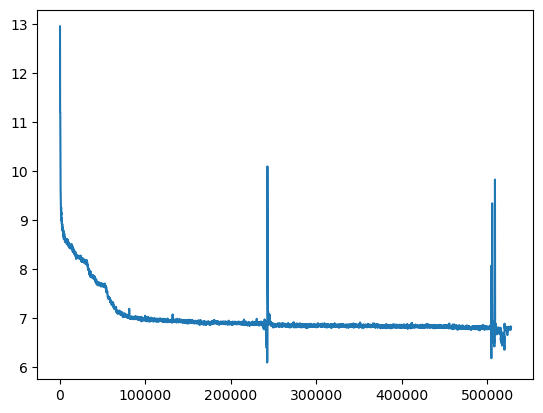

In [8]:
from matplotlib import pyplot as plt
plt.plot(steps, loss_value, label='Training Loss')

In [9]:
torch.save(PerSec.state_dict(), config["SSL"]["save Encoder path"])
torch.save(stroke_quantizer.state_dict(), config["SSL"]["save stroke quantizer path"])
torch.save(semantic_quantizer.state_dict(), config["SSL"]["save semantic quantizer path"])

In [8]:
# Decoder training
import json

import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset

import os
import pickle
from PIL import Image
from torchmetrics.text import CharErrorRate

from Encoder import PerSec
from Decoder import LSTMAttnDecoder

from custom_dataset import DecoderDataset

config = json.load(open('config.json'), 'r')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
CHAR_TO_TOKEN_FILE = config["fine-tuning"]["char to token path"]
TOKEN_TO_CHAR_FILE = config["fine-tuning"]["token to char path"]

with open(CHAR_TO_TOKEN_FILE, "rb") as f:
	char_to_token = pickle.load(f)

with open(TOKEN_TO_CHAR_FILE, "rb") as f:
	token_to_char = pickle.load(f)

def tokenizer(tensor):
	return [token_to_char[token.item()] for token in tensor]

In [10]:
torch.manual_seed(0)

if config["model"]["Vit-base Encoder"]:
	PerSec = PerSec(img_size=(32, 384), in_channels=3).to(device)
else:
	PerSec = PerSecCNN(img_size=(32, 384), in_channels=3).to(device)

Decoder = LSTMAttnDecoder(hidden_size=512, output_size=len(token_to_char)).to(device)

if config["fine-tuning"]["fine-tune on an additional dataset"]:
	PerSec.load_state_dict(torch.load(config["fine-tuning"]["Encoder path to fine-tune"]))
	Decoder.load_state_dict(torch.load(config["fine-tuning"]["Decoder path to fine-tune"]))
else:
	PerSec.load_state_dict(torch.load(config["SSL"]["save Encoder path"]))

if config["fine-tuning"]["Freeze Encoder"]:
	for param in PerSec.parameters():
		param.requires_grad = False
PerSec.lstm.requires_grad = True

In [11]:
torch.manual_seed(0)

BATCH_SIZE = config["fine-tuning"]["batch_size"]

dataset = []
for i in range(1, 4):
	dataset_dir = config["fine-tuning"][f"dataset {i}"]
	dataset_csv = config["fine-tuning"][f"dataset {i} csv"]
	if dataset_dir is not None and dataset_csv is not None:
		dataset.append(DecoderDataset(dataset_csv, dataset_dir, char_to_token))

# dataset = ConcatDataset([natural_dataset, generated_dataset])
dataset = ConcatDataset(dataset)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
cross_entropy = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(PerSec.parameters()) + list(Decoder.parameters()), lr=config["fine-tuning"]["learning_rate"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["fine-tuning"]["lr scheduler step size"], gamma=config["fine-tuning"]["lr scheduler gamma"])
cer = CharErrorRate()

In [14]:
epochs = config["fine-tuning"]["epochs"]
SOS_token = char_to_token['<SOS>']
train_cer = []
train_steps = []
val_cer = []
val_steps = []
step_count = 0

for epoch in range(epochs):
	PerSec.train()
	Decoder.train()
	for i, (imgs, labels) in enumerate(train_dataloader):
		imgs, labels = imgs.to(device), labels.to(device)
		optimizer.zero_grad()
		encoder_output, decoder_hidden = PerSec(imgs)
		decoder_input = torch.tensor([[SOS_token]] * imgs.size(0)).to(device)

		loss = 0
		predictions = []
		for t in range(labels.size(1)):
			output, decoder_hidden = Decoder(decoder_input, decoder_hidden, encoder_output)
			loss += cross_entropy(output, labels[:, t])
			predictions.append(output.argmax(1).unsqueeze(0))
			decoder_input = labels[:, t].unsqueeze(1)

		loss.backward()
		optimizer.step()

		if i % 50 == 0:
			# predictions = torch.cat(predictions, 0).transpose(0, 1)
			predictions = torch.cat(predictions)
			predictions = predictions.transpose(0, 1)
			batch_cer = sum(cer(tokenizer(pred.view(-1)), tokenizer(label.view(-1))) for pred, label in zip(predictions, labels)) / len(predictions)
			print(f"Epoch: {epoch+1}, Batch: {i}, Loss: {loss.item()}, CER: {batch_cer}")
			train_cer.append(batch_cer)
			train_steps.append(step_count)
			step_count += 100
	scheduler.step()
	
	PerSec.eval()
	Decoder.eval()
	with torch.no_grad():
		total_val_loss = 0
		total_val_cer = 0
		for i, (imgs, labels) in enumerate(val_dataloader):
			imgs, labels = imgs.to(device), labels.to(device)
			encoder_output, decoder_hidden = PerSec(imgs)
			decoder_input = torch.tensor([[SOS_token]] * imgs.size(0)).to(device)

			loss = 0
			predictions = []
			for t in range(labels.size(1)):
				output, decoder_hidden = Decoder(decoder_input, decoder_hidden, encoder_output)
				loss += cross_entropy(output, labels[:, t])
				predictions.append(output.argmax(1).unsqueeze(0))
				decoder_input = labels[:, t].unsqueeze(1)
			
			total_val_loss += loss.item()
			predictions = torch.cat(predictions, 0).transpose(0, 1)
			total_val_cer += sum(cer(tokenizer(pred.view(-1)), tokenizer(label.view(-1))) for pred, label in zip(predictions, labels)) / len(predictions)
			total_val_loss += loss.item()
		
		val_cer.append(total_val_cer / len(val_dataloader))
		val_steps.append(step_count)
		print(f"Epoch: {epoch+1}, Validation Loss: {total_val_loss/len(val_dataloader)}, Validation CER: {total_val_cer/len(val_dataloader)}")

Epoch: 1, Batch: 0, Loss: 82.35335540771484, CER: 0.9979122877120972
Epoch: 1, Batch: 50, Loss: 22.392805099487305, CER: 0.16758176684379578
Epoch: 1, Batch: 100, Loss: 19.350008010864258, CER: 0.12657569348812103
Epoch: 1, Batch: 150, Loss: 17.77531623840332, CER: 0.1181531623005867
Epoch: 1, Batch: 200, Loss: 19.153291702270508, CER: 0.13396316766738892
Epoch: 1, Batch: 250, Loss: 20.542926788330078, CER: 0.1582588255405426
Epoch: 1, Batch: 300, Loss: 18.010269165039062, CER: 0.12381542474031448
Epoch: 1, Batch: 350, Loss: 17.590227127075195, CER: 0.11854018270969391
Epoch: 1, Batch: 400, Loss: 18.341684341430664, CER: 0.13010837137699127
Epoch: 1, Batch: 450, Loss: 19.012134552001953, CER: 0.13699552416801453
Epoch: 1, Batch: 500, Loss: 16.8668212890625, CER: 0.11821408569812775
Epoch: 1, Batch: 550, Loss: 17.894617080688477, CER: 0.12653414905071259
Epoch: 1, Batch: 600, Loss: 16.296899795532227, CER: 0.1225590631365776
Epoch: 1, Batch: 650, Loss: 17.7181453704834, CER: 0.121332436

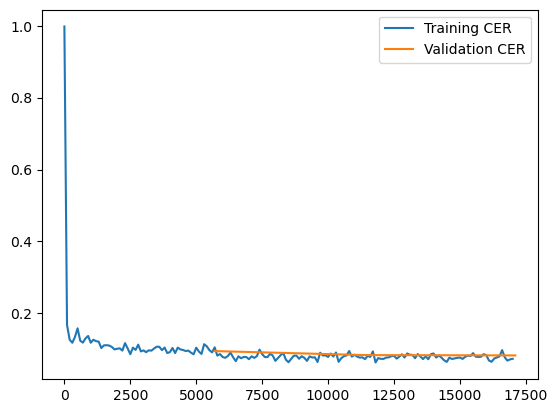

In [15]:
from matplotlib import pyplot as plt
plt.plot(train_steps, train_cer, label='Training CER')
plt.plot(val_steps, val_cer, label='Validation CER')
plt.legend()
plt.show()

In [8]:
torch.save(PerSec.state_dict(), config["fine-tuning"]["save Encoder path"])
torch.save(Decoder.state_dict(), config["fine-tuning"]["save Decoder path"])

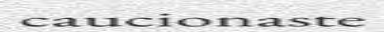

['c', 'o', 'n', 't', 'r', 'a', 't', 'a', 'r', 'a', 's', '<EOS>']


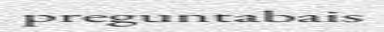

['a', 'p', 'r', 'e', 's', 'u', 'r', 'a', 's', 'e', 's', '<EOS>']


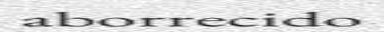

['d', 'e', 's', 'a', 'p', 'r', 'e', 'c', 'i', '<EOS>']


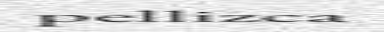

['p', 'r', 'e', 's', 'e', 'n', 't', 'a', '<EOS>']


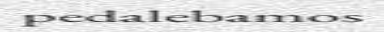

['d', 'e', 's', 'a', 'p', 'r', 'e', 't', 'a', 'r', 'a', 'i', 's', '<EOS>']


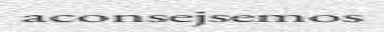

['d', 'e', 's', 'p', 'e', 'r', 't', 'a', 'r', 'a', 'm', 'o', 's', '<EOS>']


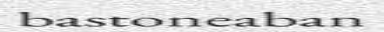

['d', 'e', 's', 'c', 'o', 'n', 'v', 'e', 'n', 'i', 'd', 'a', '<EOS>']


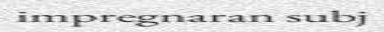

['d', 'e', 's', 'a', 'p', 'r', 'o', 'v', 'e', 'c', 'h', 'a', 'r', 'a', 's', 'u', 'b', 'j', '<EOS>']


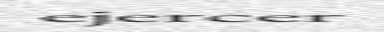

['r', 'e', 'c', 'a', 't', 'a', 'r', '<EOS>']


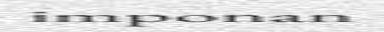

['p', 'r', 'e', 's', 'e', 'n', 't', 'a', 's', '<EOS>']


In [18]:
import PIL
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import Compose, Lambda, Resize, ToTensor, Grayscale
from torchvision.transforms import ToPILImage

import random

test_dataset_folder = config["fine-tuning"]["test dataset"]
img_size = (32, 384)

data_transform = Compose([
			Lambda(lambda img: img.convert("RGB")),
			Grayscale(num_output_channels=3),
			Resize(img_size),
			ToTensor()
		])

Decoder.eval()

test_data_files = os.listdir(test_dataset_folder)
random.shuffle(test_data_files)

with torch.no_grad():
    for filename in test_data_files[:10]:
        image = Image.open(os.path.join(test_dataset_folder, filename))
        image = data_transform(image)
        display(ToPILImage()(image))
        image_tensor = image.unsqueeze(0).to(device)
        encoder_outputs, decoder_hidden = PerSec(image_tensor)
        decoder_input = torch.tensor([[SOS_token]] * image_tensor.size(0)).to(device)
        prediction = []
        for t in range(20): 
            decoder_output, decoder_hidden = Decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            prediction.append(decoder_input.item())
            if decoder_input.item() == char_to_token['<EOS>']:
                break
        print([token_to_char[i] for i in prediction])